<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Natural%20Language%20Processing%20with%20PyTorch/Sentiment_analysis_with_Hugging_Face_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('/content/apple-twitter-sentiment-texts.csv')
data.head()

,text,sentiment
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1
1,What Happened To Apple Inc? http://t.co/FJEX...,0
2,Thank u @apple I can now compile all of the pi...,1
3,The oddly uplifting story of the Apple co-foun...,0
4,@apple can i exchange my iphone for a differen...,0


In [ ]:
data.shape

(1630, 2)

Let's label encode the sentiments

In [ ]:
from sklearn.preprocessing import LabelEncoder
lb= LabelEncoder()

In [ ]:
lb.fit(data['sentiment'])


LabelEncoder()

In [ ]:
classes= list(lb.classes_)
classes

[-1, 0, 1]

In [ ]:
data['sentiment']= lb.fit_transform(data['sentiment'])


In [ ]:
data.head()

,text,sentiment
0,Wow. Yall needa step it up @Apple RT @heynyla:...,0
1,What Happened To Apple Inc? http://t.co/FJEX...,1
2,Thank u @apple I can now compile all of the pi...,2
3,The oddly uplifting story of the Apple co-foun...,1
4,@apple can i exchange my iphone for a differen...,1


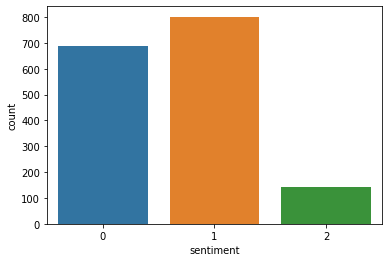

In [ ]:
sns.countplot(data['sentiment'])

In [ ]:
data.isnull().sum()

text         0
sentiment    0
dtype: int64

Data Preprocessing

In [ ]:
import nltk
import re
import string

A function to clean data it removes all the punctuation marks, urls etc

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
data['text'] = data['text'].apply(lambda x: clean_text(x))

Checking the maximum length of tweet

In [ ]:
data['text'].apply(lambda x:len(str(x).split())).max()

29

In [ ]:
data.head()

,text,sentiment
0,wow yall needa step it up apple rt heynyla mus...,0
1,what happened to apple inc aapl apple mone...,1
2,thank u apple i can now compile all of the pic...,2
3,the oddly uplifting story of the apple cofound...,1
4,apple can i exchange my iphone for a different...,1


In [ ]:
import torch
import torch.nn as nn

Importing transformers

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


Setting device to GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Choosing Sequence Length

In [ ]:
token_lens = []
for txt in data.text:
    
    tokens = tokenizer.encode(txt, max_length=512, truncation = True)
    token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

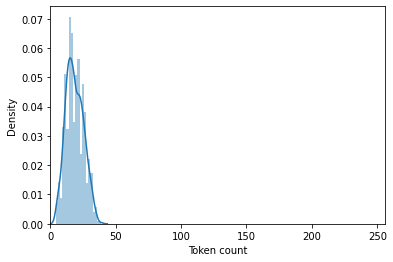

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
MAX_LEN = 50

Create Dataset

In [ ]:
class appletweet(Dataset):
  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len


  def __len__(self):
    return len(self.text)



  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        text, 
        add_special_tokens = True,
        max_length = self.max_len,
        return_token_type_ids = False,
        pad_to_max_length = True,
        #padding = True,
        return_attention_mask = True,
        return_tensors = 'pt',
        truncation = True

    ) 
    return {
        'reviews_text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'targets' : torch.tensor(target, dtype = torch.long)
    }   

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, val = train_test_split(
  data,
  test_size=0.1,
  random_state=RANDOM_SEED
)

train.shape,val.shape


((1467, 2), (163, 2))

Dataloader:- converts data to be fed into classifier

In [ ]:
def create_data_loader(data, tokenizer, max_len, batch_size):

  ds = appletweet(
      text = data.text.to_numpy(),
      targets = data.sentiment.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )
  return DataLoader(
      ds, 
      batch_size = batch_size,
      num_workers = 2
  )



BATCH_SIZE = 32

train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val, tokenizer, MAX_LEN, BATCH_SIZE)
#test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)  

In [ ]:
df = next(iter(train_data_loader))
df.keys()



dict_keys(['reviews_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(df['attention_mask'].shape)
print(df['input_ids'].shape)
print(df['targets'].shape)

torch.Size([32, 50])
torch.Size([32, 50])
torch.Size([32])


Bert Model

In [ ]:

bert_model = BertModel.from_pretrained("bert-base-cased", return_dict=False)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

    self.drop = nn.Dropout(p = 0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):

    _,pooled_output = self.bert(input_ids = input_ids,
                                attention_mask = attention_mask, return_dict=False)

    output = self.drop(pooled_output)
    return self.out(output)  

NameError: ignored

In [ ]:
n_classes = 3


In [ ]:
model = SentimentClassifier(n_classes)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = df['input_ids'].to(device)
attention_mask = df['attention_mask'].to(device)

In [ ]:
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([32, 50])
torch.Size([32, 50])


Softmax function

In [ ]:
import torch.nn.functional as F

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2943, 0.4885, 0.2171],
        [0.2366, 0.5886, 0.1748],
        [0.4625, 0.3649, 0.1727],
        [0.3433, 0.4497, 0.2070],
        [0.3922, 0.3610, 0.2468],
        [0.2540, 0.5362, 0.2098],
        [0.2847, 0.4342, 0.2811],
        [0.3939, 0.4255, 0.1805],
        [0.2217, 0.5599, 0.2185],
        [0.4234, 0.4298, 0.1468],
        [0.3718, 0.3927, 0.2354],
        [0.3353, 0.4063, 0.2584],
        [0.3159, 0.3928, 0.2912],
        [0.1993, 0.3641, 0.4366],
        [0.3159, 0.5319, 0.1522],
        [0.3333, 0.4530, 0.2137],
        [0.3775, 0.4626, 0.1600],
        [0.4107, 0.4549, 0.1344],
        [0.4119, 0.3783, 0.2098],
        [0.3324, 0.3624, 0.3053],
        [0.3394, 0.4366, 0.2240],
        [0.3005, 0.4544, 0.2451],
        [0.3600, 0.4312, 0.2087],
        [0.4356, 0.3313, 0.2331],
        [0.3827, 0.4012, 0.2161],
        [0.2922, 0.4746, 0.2332],
        [0.3139, 0.4529, 0.2332],
        [0.3360, 0.4839, 0.1801],
        [0.4615, 0.3760, 0.1625],
        [0.310

In [ ]:
model.parameters

<bound method Module.parameters of SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

Use loss function as Cross Entropy

In [ ]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr = 2e-5, correct_bias = False)

total_steps = len(train_data_loader)*EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,
                                   num_warmup_steps = total_steps, num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

Training with epoch

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler, n_examples):  

  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)
    outputs = model(input_ids=input_ids,attention_mask=attention_mask)

    _,preds = torch.max(outputs, dim = 1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)  


Evaluation

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d['input_ids'].to(device)
      attention_mask = d['attention_mask'].to(device)
      targets = d['targets'].to(device)
      outputs = model(input_ids=input_ids,attention_mask=attention_mask)

      _,preds = torch.max(outputs, dim = 1)
      loss = loss_fn(outputs, targets)

      correct_predictions +=  torch.sum(preds == targets)
      losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)  


Results

In [ ]:
from collections import defaultdict


In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,train_data_loader,loss_fn,optimizer,device,scheduler,len(train))
  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(model,val_data_loader,loss_fn,device,len(val))
  print(f'Val   loss {val_loss} accuracy {val_acc}')

  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

Epoch 1/10
----------
Train loss 0.9567856918210569 accuracy 0.5316973415132924
Val   loss 0.7508474787076315 accuracy 0.7730061349693251

Epoch 2/10
----------
Train loss 0.6671257958464001 accuracy 0.7695978186775733
Val   loss 0.4965347995360692 accuracy 0.8159509202453987

Epoch 3/10
----------
Train loss 0.4214904865492945 accuracy 0.8548057259713702
Val   loss 0.47677338620026904 accuracy 0.852760736196319

Epoch 4/10
----------
Train loss 0.2576787374589754 accuracy 0.929107021131561
Val   loss 0.44687817990779877 accuracy 0.8343558282208589

Epoch 5/10
----------
Train loss 0.14082108830790158 accuracy 0.9652351738241309
Val   loss 0.491527500251929 accuracy 0.8404907975460123

Epoch 6/10
----------
Train loss 0.08466870309380085 accuracy 0.978186775732788
Val   loss 0.41995356666545075 accuracy 0.8773006134969326

Epoch 7/10
----------
Train loss 0.04996943743595773 accuracy 0.9843217450579413
Val   loss 0.4479474077622096 accuracy 0.8957055214723927

Epoch 8/10
----------
Tra